In [1]:
import os 
import re

import pandas as pd
import numpy as np
import requests
import bs4
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Read data and check data status

In [2]:
games = pd.read_csv('data/games_detail.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88118 entries, 0 to 88117
Data columns (total 26 columns):
id                      88118 non-null int64
type                    88118 non-null object
name                    88118 non-null object
n_names                 88118 non-null int64
yearpublished           88115 non-null float64
description             88118 non-null object
minplayers              88115 non-null float64
maxplayers              88115 non-null float64
playingtime             88115 non-null float64
minplaytime             88115 non-null float64
maxplaytime             88115 non-null float64
minage                  88115 non-null float64
mechanic                73041 non-null object
subdomain               20559 non-null object
category                86620 non-null object
lang_dep                20353 non-null object
users_rated             88118 non-null int64
average_rating          88118 non-null float64
bayes_average_rating    88118 non-null float64
total_owner

In [4]:
games.head()

,id,type,name,n_names,yearpublished,description,minplayers,maxplayers,playingtime,minplaytime,...,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,89371,boardgame,The Russo-Georgian War of 2008,1,2010.0,The Russo-Georgian War of 2008 is a DTP simula...,1.0,2.0,90.0,90.0,...,8,7.31250,0.0000,21,0,4,4,4,1,3.0000
1,89376,boardgame,Früher oder Später,1,2009.0,Fr&uuml;her oder Sp&auml;ter is a card game is...,2.0,5.0,30.0,30.0,...,1,4.00000,0.0000,3,1,0,0,0,1,1.0000
2,89378,boardgame,Supervivencia,1,1990.0,A game about survival. The players represent a...,2.0,6.0,80.0,80.0,...,1,5.00000,0.0000,0,0,0,0,1,1,2.0000
3,5988,boardgame,Wings Over France,1,1992.0,"Wings Over France is a solitaire WWI wargame, ...",1.0,1.0,60.0,60.0,...,46,7.47826,5.5944,107,7,25,66,29,9,3.2222
4,40134,boardgame,Le Tour Cycliste,1,0.0,French cycling game released at the end of the...,2.0,6.0,0.0,0.0,...,0,0.00000,0.0000,1,0,0,1,0,0,0.0000


In [5]:
# check if there is any duplication data due to faulty data processing
games.duplicated().sum()

0

In [6]:
# check if there are columns with large portion of null value
games.isnull().sum() / games.shape[0]

id                      0.000000
type                    0.000000
name                    0.000000
n_names                 0.000000
yearpublished           0.000034
description             0.000000
minplayers              0.000034
maxplayers              0.000034
playingtime             0.000034
minplaytime             0.000034
maxplaytime             0.000034
minage                  0.000034
mechanic                0.171100
subdomain               0.766688
category                0.017000
lang_dep                0.769026
users_rated             0.000000
average_rating          0.000000
bayes_average_rating    0.000000
total_owners            0.000000
total_traders           0.000000
total_wanters           0.000000
total_wishers           0.000000
total_comments          0.000000
total_weights           0.000000
average_weight          0.000000
dtype: float64

# Clean null data

In [7]:
# Keep the original copy in memory for future use
games_cleaned = games.copy()

In [8]:
# drop two columns which contain many null values
games_cleaned.drop(labels=['subdomain', 'lang_dep'], axis=1, inplace=True)

In [9]:
# check the distribution of null data
pd.concat([games_cleaned.isnull().sum() / games_cleaned.shape[0], games_cleaned.isnull().sum()], axis=1)

,0,1
id,0.000000,0
type,0.000000,0
name,0.000000,0
n_names,0.000000,0
yearpublished,0.000034,3
description,0.000000,0
minplayers,0.000034,3
maxplayers,0.000034,3
playingtime,0.000034,3
minplaytime,0.000034,3


In [10]:
# drop rows contain null data
games_cleaned.dropna(inplace=True)

In [11]:
# check remaining data
games_cleaned.shape

(72180, 24)

# Clean unusual or unreasonable data

In [12]:
games_cleaned.describe()

,id,n_names,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000,72180.000000
mean,86667.107828,1.529371,1824.841147,2.004253,5.848698,57.924079,51.577515,57.121239,7.383416,141.052909,4.429646,1.246493,263.196426,8.785425,10.903893,39.004807,41.416223,12.210779,0.946668
std,68146.635229,4.621345,566.218378,0.860355,59.314011,366.763899,352.961738,366.794762,5.015978,1113.145838,2.880982,2.380059,1560.568889,38.733187,53.608424,235.104995,254.530998,95.353399,1.193385
min,1.000000,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24134.750000,1.000000,1987.000000,2.000000,2.000000,10.000000,10.000000,10.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,67290.500000,1.000000,2005.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,3.000000,5.500000,0.000000,9.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
75%,150703.250000,1.000000,2012.000000,2.000000,6.000000,60.000000,60.000000,60.000000,12.000000,21.000000,6.735702,0.000000,70.000000,3.000000,3.000000,9.000000,10.000000,2.000000,2.000000
max,218270.000000,764.000000,2019.000000,50.000000,11299.000000,60120.000000,60120.000000,60120.000000,120.000000,64926.000000,10.000000,8.464010,90720.000000,1763.000000,1740.000000,8394.000000,13492.000000,6366.000000,5.000000


### Publish year

In [13]:
cond_1 = games_cleaned['yearpublished'] > 1900
cond_2 = games_cleaned['yearpublished'] <= 2017
games_cleaned[cond_1 & cond_2].shape

(65233, 24)

In [14]:
games_cleaned = games_cleaned[cond_1 & cond_2]

### Number of players

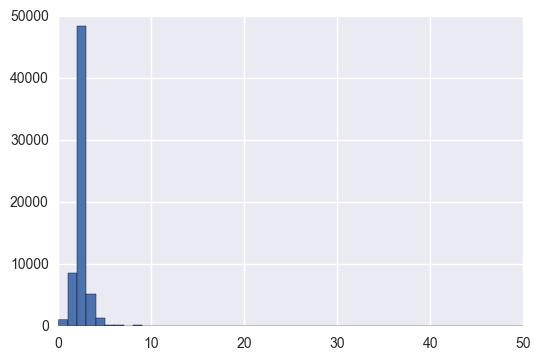

In [15]:
games_cleaned['minplayers'].hist(bins=50)

In [16]:
games_cleaned = games_cleaned[games_cleaned['minplayers'] <= 10]

In [17]:
games_cleaned.shape[0]

65198

In [18]:
cond = games_cleaned['maxplayers'] == 0 
print(games_cleaned[cond].shape[0])
games_cleaned[cond][['name', 'type', 'minplayers', 'maxplayers']].head(10)

3287


,name,type,minplayers,maxplayers
50,Whirred PLAY,boardgame,4.0,0.0
76,Dark Gothic: Curse of the Werewolf Game Supple...,expansion,0.0,0.0
108,Collector's Edition Girls' Night StoryClub,boardgame,2.0,0.0
120,Hit List,boardgame,2.0,0.0
124,"The Rough Riders: A Volley, Bayonet, & Glory S...",expansion,2.0,0.0
149,The Great Dreidel Race!,boardgame,2.0,0.0
173,Iskelmäkaraoke,boardgame,3.0,0.0
185,Robotech RPG Tactics,boardgame,2.0,0.0
187,Swipe Out!,boardgame,0.0,0.0
277,"Dust Tactics: Allies P-48 Pelican – ""Bellowing...",expansion,0.0,0.0


In [19]:
(games_cleaned['type'] == 'expansion').sum()

11178

In [20]:
games_cleaned = games_cleaned[games_cleaned['type'] != 'expansion']

In [21]:
set(games_cleaned['type'])

{'boardgame'}

In [22]:
games_cleaned.drop('type', axis=1, inplace=True)

In [23]:
cond = games_cleaned['minplayers'] > games_cleaned['maxplayers']
print(cond.sum())

1756


In [24]:
cond = games_cleaned['minplayers'] > games_cleaned['maxplayers']
games_cleaned.loc[cond, 'maxplayers'] = games_cleaned[cond]['minplayers']

In [25]:
games_cleaned.loc[50, ['minplayers', 'maxplayers']]

minplayers    4
maxplayers    4
Name: 50, dtype: object

In [26]:
games_cleaned.shape[0]

54020

In [27]:
cond = (games_cleaned['minplayers'] == 0) | (games_cleaned['maxplayers'] == 0)
print(cond.sum())

661


In [28]:
cond = (games_cleaned['minplayers'] != 0) & (games_cleaned['maxplayers'] != 0)
games_cleaned = games_cleaned[cond]

In [29]:
games_cleaned.shape[0]

53359

In [30]:
games_cleaned.describe()

,id,n_names,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000,53359.000000
mean,78396.048014,1.490658,1999.359021,2.046478,5.859049,57.163702,50.944508,56.690868,7.299443,164.886242,4.313405,1.264469,261.354373,9.849304,11.241046,43.483855,48.173185,14.686932,0.937618
std,67020.690498,4.069358,17.621473,0.710910,68.166030,409.003166,393.189008,409.024174,4.826266,1265.791327,2.777323,2.388365,1703.448951,43.658734,60.209537,268.152589,287.819735,108.849032,1.138848
min,1.000000,1.000000,1901.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20030.000000,1.000000,1991.000000,2.000000,2.000000,15.000000,10.000000,15.000000,4.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43375.000000,1.000000,2005.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,3.000000,5.363330,0.000000,8.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
75%,140623.000000,1.000000,2012.000000,2.000000,6.000000,60.000000,60.000000,60.000000,12.000000,21.500000,6.474120,0.000000,56.000000,3.000000,2.000000,7.000000,11.000000,3.000000,1.942600
max,218270.000000,764.000000,2017.000000,10.000000,11299.000000,60120.000000,60120.000000,60120.000000,99.000000,64926.000000,10.000000,8.464010,90720.000000,1763.000000,1740.000000,8394.000000,13492.000000,6366.000000,5.000000


### Playing time

In [31]:
cond = games_cleaned['maxplaytime'] < games_cleaned['minplaytime']
print(cond.sum())
games_cleaned[cond][['id', 'name', 'minplaytime', 'maxplaytime']].head(10)

719


,id,name,minplaytime,maxplaytime
108,176683,Collector's Edition Girls' Night StoryClub,30.0,0.0
216,179596,3 and C,2.0,0.0
670,187714,Exultate Deo -The Fluffy Rite-,30.0,0.0
673,187711,Kaiten: Die Sushi-Bar,60.0,0.0
688,192923,Barn Raiser,20.0,0.0
954,177146,Climb ON!,60.0,0.0
985,193647,Blitzkrieg V3,30.0,8.0
1069,213884,Starcall,30.0,0.0
1070,213885,Heartbreak EP,30.0,0.0
1112,176545,Moriyamics,10.0,0.0


In [32]:
games_cleaned.loc[cond, 'maxplaytime'] = games_cleaned[cond]['minplaytime']

In [33]:
cond = (games_cleaned['maxplaytime'] == 0) | (games_cleaned['minplaytime'] == 0)
print(cond.sum())

8795


In [34]:
games_cleaned[games_cleaned['maxplaytime'] == 0][['name', 'minplaytime', 'maxplaytime']].head(10)

,name,minplaytime,maxplaytime
16,Brawl Inn,0.0,0.0
23,Wicce Hearts,0.0,0.0
67,Espresso Dice,0.0,0.0
69,Grand Prix,0.0,0.0
73,Wheelspin No 1 World Formula Grand Prix,0.0,0.0
75,Grand Prix Championship,0.0,0.0
81,Totalisator Greyhound Racing Game,0.0,0.0
119,House Rules for Napoleonic Wargaming,0.0,0.0
120,Hit List,0.0,0.0
129,The Brownie Game,0.0,0.0


In [35]:
cond_1 = games_cleaned['minplaytime'] != 0
cond_2 = games_cleaned['maxplaytime'] != 0

games_cleaned = games_cleaned[cond_1 & cond_2]
print(games_cleaned.shape[0])

44564


In [36]:
cond = games_cleaned['playingtime'] > games_cleaned['maxplaytime']
print(cond.sum())

0


### Minimum age

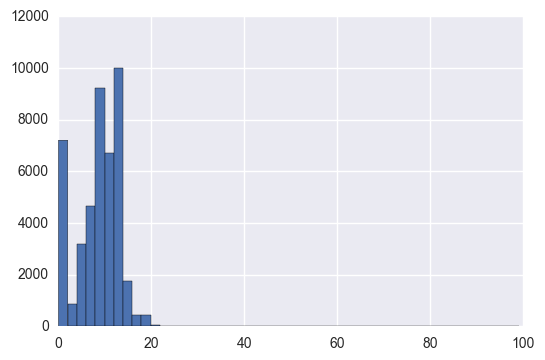

In [37]:
games_cleaned['minage'].hist(bins=50)

In [38]:
(games_cleaned['minage'] > 30).sum()

8

In [39]:
games_cleaned[games_cleaned['minage'] > 30][['name', 'minage', 'category']]

,name,minage,category
11222,South African Railroads,42.0,"Economic,Trains,Transportation"
26264,The BGG Admin Game: The Octavian Edition,99.0,Party Game
27234,Eco Town,36.0,"Children's Game,City Building"
47921,La Boîte à énigmes junior,45.0,"Card Game,Children's Game,Fantasy,Trivia"
50827,Eight Epics: Hakkenden,38.0,Dice
55829,HTPsim,90.0,"Racing,Sports"
67664,Grand Galop,45.0,"Animals,Children's Game,Dice,Movies / TV / Rad..."
68280,The 70's Game,35.0,Trivia


We will clean up minage column after we encode mechanic and category columns.

# Encode mechanic and category columns

In [40]:
games_cleaned['mechanic'].head(10)

0                                       Hex-and-Counter
1                                       Hand Management
2            Card Drafting,Roll / Spin and Move,Trading
3     Action Point Allowance System,Campaign / Battl...
5                                       Hex-and-Counter
6                                         Area Movement
7                                  Roll / Spin and Move
10                                      Hand Management
11                                      Hex-and-Counter
13                                         Dice Rolling
Name: mechanic, dtype: object

In [41]:
def get_cate(cate='mechanic'):
    # get mechanics or category lists from BGG website.
    if cate == 'mechanic':
        url = 'https://boardgamegeek.com/browse/boardgamemechanic'
    elif cate == 'category':
        url = 'https://boardgamegeek.com/browse/boardgamecategory'
    response = requests.get(url)
    if response.status_code != 200:
        print('fail to access website.')
        print('response code: {}'.format(response.status_code))
        return None

    soup = bs4.BeautifulSoup(response.content, 'lxml')
    tables = soup.find_all('table', {'width': '100%', 'class': 'forum_table'})
    if len(tables) != 1:
        print('Warning: more than one table are found!')
        return None

    table = tables[0]
    cate_links = table.find_all('a')
    cate_list = [str(link.string) for link in cate_links]

    return cate_list

In [42]:
mech_list, cate_list = get_cate('mechanic'), get_cate('category')

In [43]:
print(len(mech_list))
print(mech_list[:10])
print('\n')
print(len(cate_list))
print(cate_list[:10])

51
['Acting', 'Action / Movement Programming', 'Action Point Allowance System', 'Area Control / Area Influence', 'Area Enclosure', 'Area Movement', 'Area-Impulse', 'Auction/Bidding', 'Betting/Wagering', 'Campaign / Battle Card Driven']


84
['Abstract Strategy', 'Action / Dexterity', 'Adventure', 'Age of Reason', 'American Civil War', 'American Indian Wars', 'American Revolutionary War', 'American West', 'Ancient', 'Animals']


In [44]:
def check_cate(row, cate_list, cate='mechanic'):
    # check if every games mechanics and categories are in the lists.
    cates = row[cate].split(',')
    cate_set = set(cate_list)
    return cate_set.issuperset(cates)

In [45]:
# check if all values are in the set
check_results = games_cleaned.apply(lambda row: check_cate(row, mech_list, cate='mechanic'), axis=1)
(~check_results).sum()

0

In [46]:
# check if all values are in the set
check_results = games_cleaned.apply(lambda row: check_cate(row, cate_list, cate='category'), axis=1)
(~check_results).sum()

0

In [47]:
def encoder(row, cate_list, cate='mechanic'):
    # encode each machanic and category as a category variable with value 0 or 1.
    encoded_result = dict(zip(cate_list, [0]*len(cate_list)))
    cates = row[cate].split(',')
    for cate in cates:
        encoded_result[cate] = 1
    return pd.Series(encoded_result)

In [48]:
games_cleaned[mech_list] = games_cleaned.apply(lambda row: encoder(row, mech_list, cate='mechanic'), axis=1)

In [49]:
games_cleaned[cate_list] = games_cleaned.apply(lambda row: encoder(row, cate_list, cate='category'), axis=1)

In [50]:
ind = np.random.randint(0, games_cleaned.shape[0])
sample = games_cleaned.iloc[ind]
print(sample['mechanic'])
print(sample[mech_list][sample[mech_list] == 1])

Hex-and-Counter
Hex-and-Counter    1
Name: 27511, dtype: object


In [51]:
ind = np.random.randint(0, games_cleaned.shape[0])
sample = games_cleaned.iloc[ind]
print(sample['category'])
print(sample[cate_list][sample[cate_list] == 1])

Card Game,Political
Card Game    1
Political    1
Name: 34035, dtype: object


In [52]:
games_cleaned.shape[1]

157

In [53]:
games.shape[1] + len(mech_list) + len(cate_list) - 3 # subtract columns: type, subdomain and lang_dep

158

In [54]:
[col for col in cate_list if col in mech_list]

['Memory']

In [55]:
def memory_cate_fix(row):
    cates_category = row['category'].split(',')
    cates_mechanic = row['mechanic'].split(',')
    if 'Memory' in cates_category or 'Memory' in cates_mechanic:
        memory = {'Memory': 1}
    else:
        memory = {'Memory': 0}
    return pd.Series(memory)

In [56]:
games_cleaned['Memory'] = games_cleaned.apply(lambda row: memory_cate_fix(row), axis=1)

In [57]:
games_cleaned[games_cleaned['Memory']==1][['mechanic', 'category']].head(10)

,mechanic,category
28,"Card Drafting,Hand Management,Memory,Set Colle...","Card Game,Children's Game,Educational,Memory,R..."
31,"Memory,Set Collection","Card Game,Real-time"
45,"Dice Rolling,Memory,Roll / Spin and Move","Card Game,Dice,Memory,Party Game"
109,"Roll / Spin and Move,Set Collection","Adventure,Children's Game,Memory,Movies / TV /..."
117,"Memory,Roll / Spin and Move","Educational,Memory,Religious"
121,"Memory,Roll / Spin and Move,Simulation","American West,Educational,Memory,Religious,Trivia"
125,"Action Point Allowance System,Memory","Electronic,Horror,Memory,Racing"
218,"Memory,Set Collection","Card Game,Party Game"
251,"Memory,Roll / Spin and Move","Memory,Music,Trivia"
257,"Betting/Wagering,Memory,Roll / Spin and Move","Memory,Party Game,Real-time"


In [58]:
games_cleaned.drop(['mechanic', 'category'], axis=1, inplace=True)

# Minimum age revisit

In [59]:
cond_1 = games_cleaned['Children\'s Game'] == 1
cond_2 = games_cleaned['minage'] > 18
print((cond_1 & cond_2).sum())
games_cleaned[cond_1 & cond_2][['name', 'minage']]

5


,name,minage
27234,Eco Town,36.0
47921,La Boîte à énigmes junior,45.0
67664,Grand Galop,45.0
75537,Le Cochon Qui Rit Encore Plus,30.0
76130,Power Rangers Wild Force Circle of Power Game,30.0


In [60]:
mean_age_children = games_cleaned.loc[cond_1 & ~cond_2, 'minage'].mean()

In [61]:
mean_age_children

4.950326797385621

In [62]:
games_cleaned.loc[cond_1 & cond_2, 'minage'] = mean_age_children

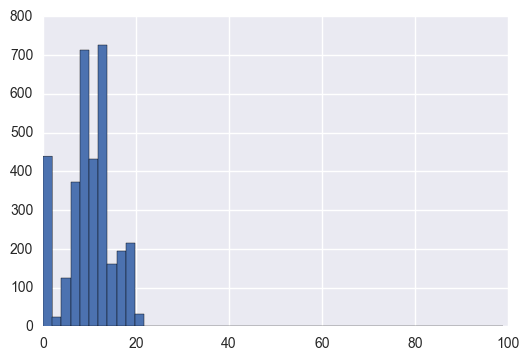

In [63]:
games_cleaned[games_cleaned['Party Game']==1]['minage'].hist(bins=50)

In [64]:
cond_1 = games_cleaned['Party Game'] == 1
cond_2 = games_cleaned['minage'] > 25
games_cleaned[cond_1 & cond_2][['name', 'minage']]

,name,minage
26264,The BGG Admin Game: The Octavian Edition,99.0
52619,Kill dog,30.0


In [65]:
mean_age_party = games_cleaned[games_cleaned['Party Game'] == 1]['minage'].mean()

In [66]:
games_cleaned.loc[26264, 'minage'] = mean_age_party

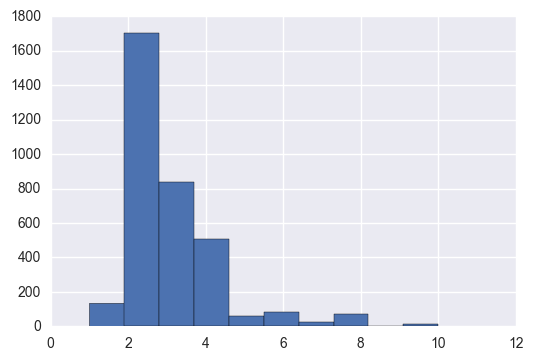

In [67]:
games_cleaned[games_cleaned['Party Game'] == 1]['minplayers'].hist()

In [68]:
cond_1 = games_cleaned['Party Game'] == 1
cond_2 = games_cleaned['maxplayers'] < 3
print((cond_1 & cond_2).sum())
games_cleaned[cond_1 & cond_2][['name', 'minplayers', 'maxplayers']].head(10)

142


,name,minplayers,maxplayers
108,Collector's Edition Girls' Night StoryClub,2.0,2.0
486,Guts the Game,2.0,2.0
1710,SHOC,2.0,2.0
3934,The Big Payoff,2.0,2.0
4824,Cranium Letter Line-Up,2.0,2.0
6299,Scene it? Jr.,2.0,2.0
6739,Hannah Montana Girl Talk,2.0,2.0
9774,Be A Bard,2.0,2.0
10300,Vidi Kompaktspiel,2.0,2.0
11964,Mr. Peter Piper,2.0,2.0


In [69]:
mean_maxplayers_party = games_cleaned[cond_1 & ~cond_2]['maxplayers'].mean()

In [70]:
games_cleaned.loc[cond_1 & cond_2, 'maxplayers'] = mean_maxplayers_party

In [71]:
features = [feature for feature in games_cleaned.columns if feature not in mech_list + cate_list]

In [72]:
games_cleaned[features].describe()

,id,n_names,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000
mean,79238.000942,1.554753,2001.083206,2.055269,5.926932,68.359034,60.998743,68.359034,7.895838,196.204313,4.583616,1.463719,308.949197,11.611996,13.266605,51.472534,57.054349,17.424558,1.029180
std,68164.220203,4.437296,15.888733,0.727093,73.117442,446.678216,429.529777,446.678216,4.491565,1382.883221,2.679284,2.514378,1860.015319,47.553244,65.663142,292.652773,314.151647,118.908536,1.151054
min,1.000000,1.000000,1901.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18187.750000,1.000000,1994.000000,2.000000,3.000000,20.000000,20.000000,20.000000,5.000000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49702.500000,1.000000,2006.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,4.000000,5.540840,0.000000,11.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000
75%,143767.500000,1.000000,2012.000000,2.000000,6.000000,60.000000,60.000000,60.000000,12.000000,31.000000,6.542488,5.380682,78.000000,4.000000,3.000000,10.000000,15.000000,4.000000,2.000000
max,218270.000000,764.000000,2017.000000,10.000000,11299.000000,60120.000000,60120.000000,60120.000000,90.000000,64926.000000,10.000000,8.464010,90720.000000,1763.000000,1740.000000,8394.000000,13492.000000,6366.000000,5.000000


In [75]:
games_cleaned.shape[0]

44564

In [73]:
games_cleaned.to_csv('./data/games_detail_cleaned.csv', encoding='utf-8', index=False)

In [76]:
os.system('jupyter nbconvert --to html 00_cleaning_00.ipynb')

0